<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1KerrasUnbalancedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full.csv


# Data Exploration

Check column types and if any null

In [47]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Check how balanced data is

(41188, 21)
No claim 36548
Claim 4640
Claim proportion 11.27%


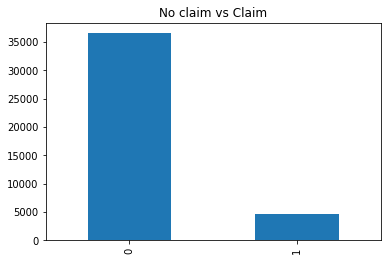

In [3]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

Check if any missing features

In [4]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

## Data preprocessing

Check distribution of numerical data

In [ ]:
df.groupby('target').hist(figsize = (16,18))

[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]


Binning

            job   marital  ... cons.price.idx_binned cons.conf.idx_binned
0     housemaid   married  ...                     3                    3
1      services   married  ...                     3                    3
2      services   married  ...                     3                    3
3        admin.   married  ...                     3                    3
4      services   married  ...                     3                    3
5      services   married  ...                     3                    3
6        admin.   married  ...                     3                    3
7   blue-collar   married  ...                     3                    3
8    technician    single  ...                     3                    3
9      services    single  ...                     3                    3
10  blue-collar   married  ...                     3                    3
11     services    single  ...                     3                    3
12  blue-collar    single  ...        

target
0    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

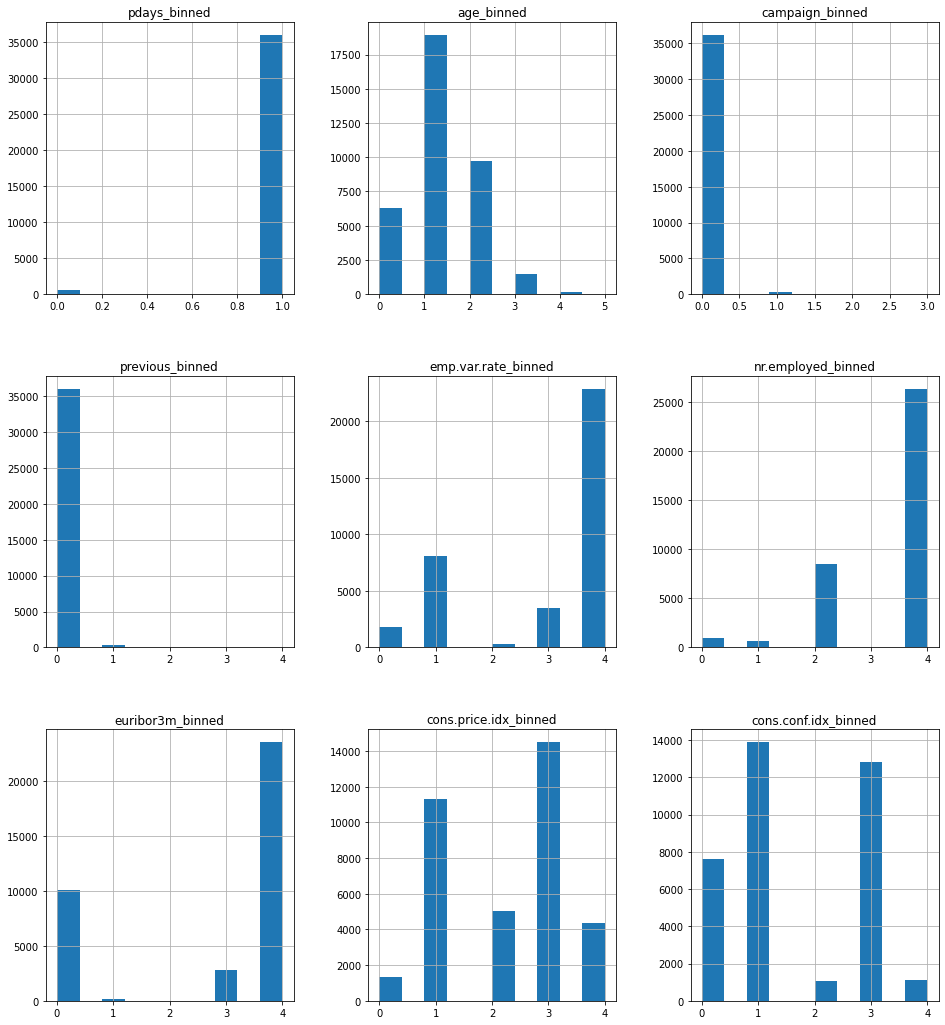

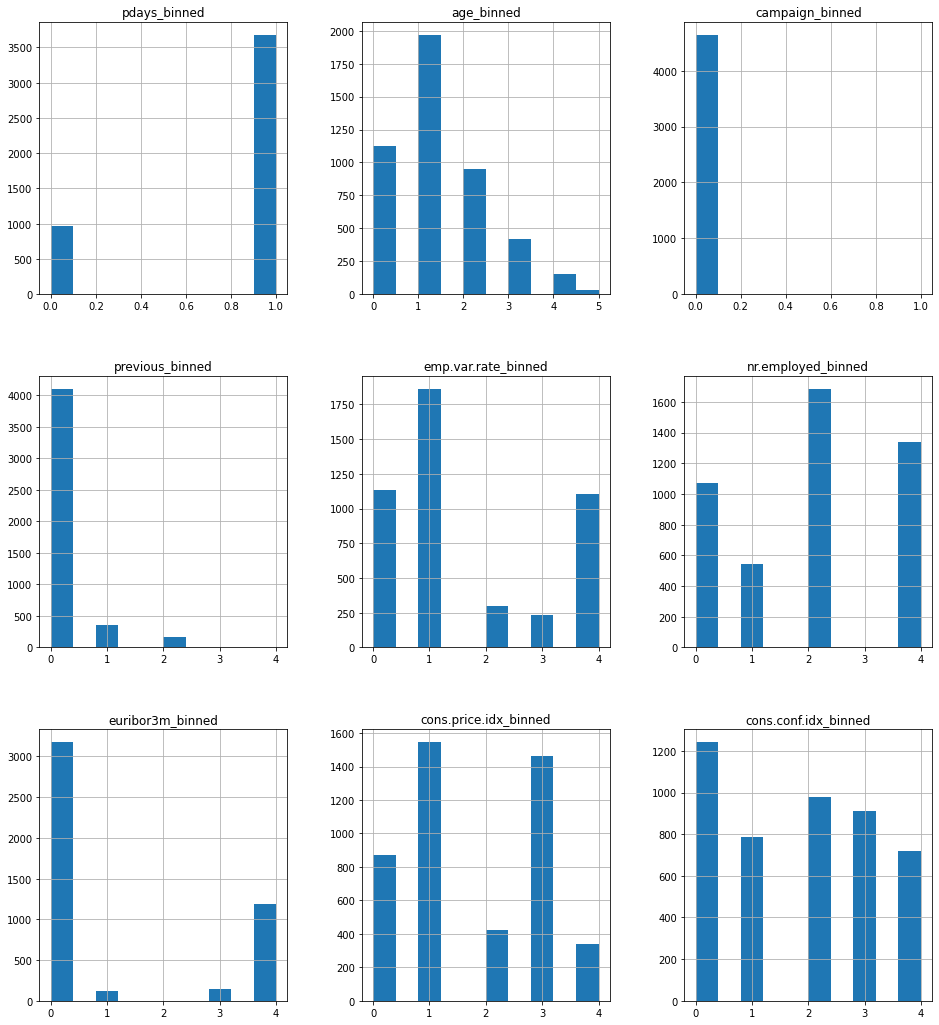

In [16]:
processing_df = df

processing_df['pdays_binned'] = pd.cut(processing_df['pdays'], bins=2,labels=False,precision=1)
processing_df = processing_df.drop('pdays', axis=1)
processing_df['age_binned'] = pd.cut(processing_df['age'], bins=6,labels=False,precision=1)
processing_df = processing_df.drop('age', axis=1)
processing_df['campaign_binned'] = pd.cut(processing_df['campaign'], bins=4,labels=False,precision=1)
processing_df = processing_df.drop('campaign', axis=1)
processing_df['previous_binned'] = pd.cut(processing_df['previous'], bins=5,labels=False,precision=1)
processing_df = processing_df.drop('previous', axis=1)
processing_df['emp.var.rate_binned'] = pd.cut(processing_df['emp.var.rate'], bins=5,labels=False,precision=1)
processing_df = processing_df.drop('emp.var.rate', axis=1)
processing_df['nr.employed_binned'] = pd.cut(processing_df['nr.employed'], bins=5,labels=False,precision=1)
processing_df = processing_df.drop('nr.employed', axis=1)
processing_df['euribor3m_binned'] = pd.cut(processing_df['euribor3m'], bins=5,labels=False,precision=1)
processing_df = processing_df.drop('euribor3m', axis=1)
processing_df['cons.price.idx_binned'] = pd.cut(processing_df['cons.price.idx'], bins=5,labels=False,precision=1)
processing_df = processing_df.drop('cons.price.idx', axis=1)
processing_df['cons.conf.idx_binned'] = pd.cut(processing_df['cons.conf.idx'], bins=5,labels=False,precision=1)
processing_df = processing_df.drop('cons.conf.idx', axis=1)

# Remove - duration as only for benchmark
processing_df = processing_df.drop('duration', 1)

Encode categorical features

In [19]:
categorical_columns = ["job","housing", "marital","education","default","loan","contact","month","day_of_week","poutcome"]

# Using one-hot encoding as no order so don't confuse model
for column in categorical_columns:
    tempdf = pd.get_dummies(processing_df[column], prefix=column)
    processing_df = pd.merge(
        left=processing_df,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    processing_df = processing_df.drop(columns=column)

Check correlation of features

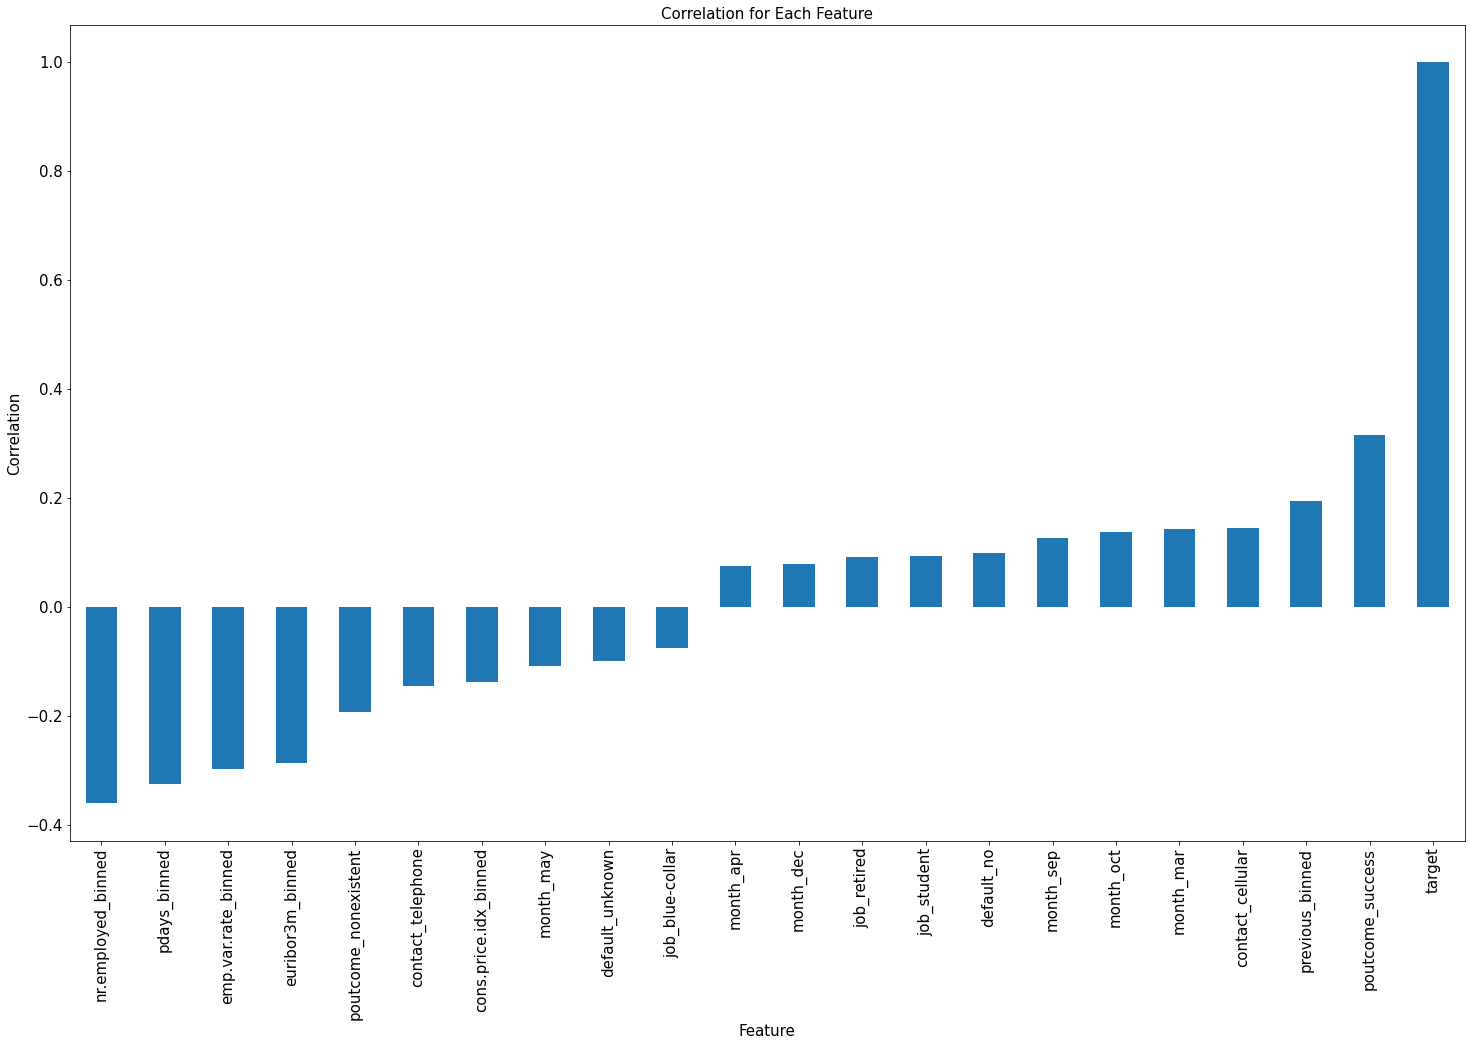

In [20]:
# # Create correlation matrix
std_features_keep = processing_df
corr_matrix = std_features_keep.corr()['target'].sort_values()
threshold = 0.07

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

# Metrics

In [21]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [22]:
from sklearn.metrics import confusion_matrix

def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('% right for no: ', (cm[0][0]/(cm[0][0] + cm[0][1]))*100)
  print('% right for yes: ', (cm[1][1]/(cm[1][1] + cm[1][0]))*100)
  return cm

def plot_cm(labels, predictions, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

In [23]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

In [63]:
def visualise_training_history_accuracy(ax, history, title):
  # Get training and test accuracy histories
  training_accuracy = history.history["accuracy"]
  test_accuracy = history.history["val_accuracy"]
  epoch_count = range(1, len(training_accuracy) + 1)
  ax.plot(epoch_count, training_accuracy, "r--")
  ax.plot(epoch_count, test_accuracy, "b-")
  # Visualize accuracy history
  ax.legend(["Training Accuracy", "Test Accuracy"])
  ax.title.set_text(title)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Accuracy Score")

In [64]:
def visualise_training_history_loss(ax, history, title):
  # Get training and test loss histories
  training_loss = history.history["loss"]
  test_loss = history.history["val_loss"]
  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)
  # Visualize loss history
  ax.plot(epoch_count, training_loss, "r--")
  ax.plot(epoch_count, test_loss, "b-")
  ax.legend(["Training Loss", "Test Loss"])
  ax.title.set_text(title)
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")

## Neural Network

In [26]:
BATCH_SIZE = 2048

import keras
from keras import backend as K
import tensorflow as tf
from keras import layers

def build_model(number_inputs,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  network = keras.Sequential()
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=16, activation="relu",input_dim=number_inputs))
  # Add fully connected layer with a ReLU activation function
  network.add(layers.Dense(units=480, activation="relu"))
  # Add fully connected layer with a sigmoid activation function
  network.add(layers.Dense(units=1, activation="sigmoid",bias_initializer=output_bias))

  network.compile(
    optimizer="rmsprop",
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )

  return network

# Split Training and Test Data

In [27]:
from sklearn.model_selection import train_test_split

X = std_features_keep.drop("target", axis=1)
y = df['target']

labels = X.columns.values
number_inputs = len(X.columns)

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

Mean: 0
Standard deviation: 1.0


# Plain Model

In [28]:
plain_model = build_model(number_inputs)

history_plain = plain_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(X_test, y_test), 
    shuffle=True)

Epoch 1/100
20/20 [==============================] - 6s 109ms/step - loss: 0.5707 - tp: 782.0000 - fp: 7594.0000 - tn: 27131.0000 - fn: 3621.0000 - accuracy: 0.7134 - precision: 0.0934 - recall: 0.1776 - auc: 0.4582 - prc: 0.1089 - val_loss: 0.3759 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1823.0000 - val_fn: 237.0000 - val_accuracy: 0.8850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5905 - val_prc: 0.2089
Epoch 2/100
20/20 [==============================] - 0s 17ms/step - loss: 0.3369 - tp: 227.0000 - fp: 85.0000 - tn: 34640.0000 - fn: 4176.0000 - accuracy: 0.8911 - precision: 0.7276 - recall: 0.0516 - auc: 0.6686 - prc: 0.3162 - val_loss: 0.3104 - val_tp: 25.0000 - val_fp: 10.0000 - val_tn: 1813.0000 - val_fn: 212.0000 - val_accuracy: 0.8922 - val_precision: 0.7143 - val_recall: 0.1055 - val_auc: 0.7354 - val_prc: 0.3755
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.2964 - tp: 732.0000 - fp: 356.0000 - tn: 34369.0000 - fn:

loss :  0.2871525287628174
tp :  59.0
fp :  40.0
tn :  1783.0
fn :  178.0
accuracy :  0.8941747546195984
precision :  0.5959596037864685
recall :  0.24894514679908752
auc :  0.7855820655822754
prc :  0.43055620789527893
f1 score: 0.35119047619047616

% right for no:  97.80581459133296
% right for yes:  24.894514767932492


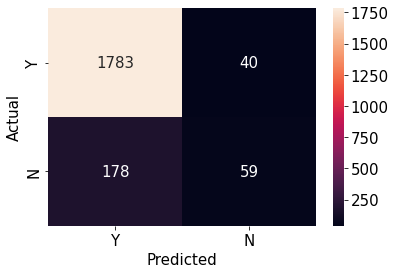

In [29]:
evaluation_results = plain_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = plain_model.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(plain_model, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

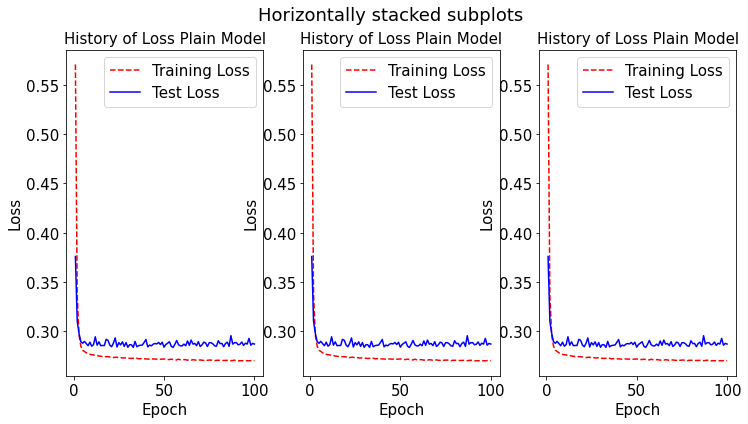

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,6))
fig.suptitle('Horizontally stacked subplots')
visualise_training_history_loss(ax1, history_plain,"History of Loss Plain Model")
visualise_training_history_loss(ax2, history_plain,"History of Loss Plain Model")
visualise_training_history_loss(ax3, history_plain,"History of Loss Plain Model")

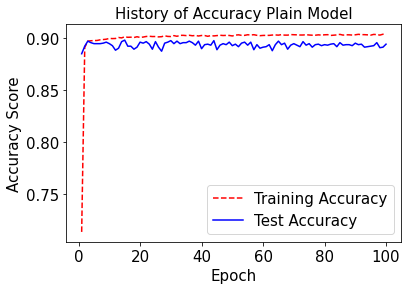

In [31]:
visualise_training_history_accuracy(history_plain,"History of Accuracy Plain Model")

# Weighted model

In [32]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = ((1 / no_claim_count) * (total_count) / 2.0 )
weight_claim = (((1 / claim_count) * (total_count) / 2.0 )) 
print("no claim:  " + str(weight_no_claim))
print("claim:  " + str(weight_claim))
class_weights = {0: weight_no_claim, 1: weight_claim}

no claim:  0.5634781656999015
claim:  4.438362068965517


In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

initial_bias = np.log([claim/no_claim])
model_weighted = build_model(number_inputs, initial_bias)

callbacks = [EarlyStopping(monitor="val_loss", patience=3),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
    class_weight=class_weights
)

Epoch 1/100
20/20 [==============================] - 4s 59ms/step - loss: 0.6624 - tp: 2073.0000 - fp: 5375.0000 - tn: 31173.0000 - fn: 2567.0000 - accuracy: 0.8072 - precision: 0.2783 - recall: 0.4468 - auc: 0.6967 - prc: 0.2963 - val_loss: 0.5140 - val_tp: 158.0000 - val_fp: 392.0000 - val_tn: 1431.0000 - val_fn: 79.0000 - val_accuracy: 0.7714 - val_precision: 0.2873 - val_recall: 0.6667 - val_auc: 0.7705 - val_prc: 0.3846
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.5573 - tp: 2965.0000 - fp: 7703.0000 - tn: 27022.0000 - fn: 1438.0000 - accuracy: 0.7664 - precision: 0.2779 - recall: 0.6734 - auc: 0.7813 - prc: 0.3927 - val_loss: 0.4953 - val_tp: 161.0000 - val_fp: 344.0000 - val_tn: 1479.0000 - val_fn: 76.0000 - val_accuracy: 0.7961 - val_precision: 0.3188 - val_recall: 0.6793 - val_auc: 0.7843 - val_prc: 0.4310
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.5437 - tp: 2916.0000 - fp: 6561.0000 - tn: 28164.0000 - fn: 1487.0

Evaluation

loss :  0.5800162553787231
tp :  161.0
fp :  356.0
tn :  1467.0
fn :  76.0
accuracy :  0.7902912497520447
precision :  0.3114120066165924
recall :  0.6793248653411865
auc :  0.7903279066085815
prc :  0.4466177821159363
f1 score: 0.4270557029177719

% right for no:  80.4717498628634
% right for yes:  67.9324894514768


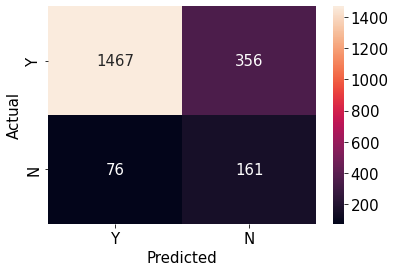

In [34]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

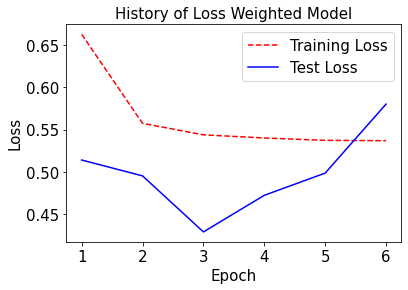

In [35]:
visualise_training_history_loss(history_weighted,"History of Loss Weighted Model")

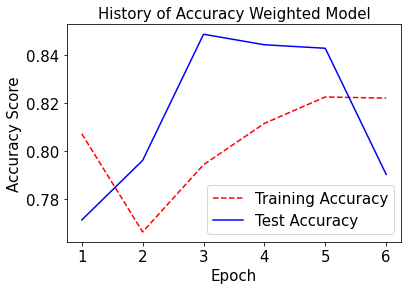

In [36]:
visualise_training_history_accuracy(history_weighted,"History of Accuracy Weighted Model")

# Resampling

In [37]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=RANDOM_SEED, sampling_strategy=1.0);
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

No claim Resampled 34725
Claim Resampled 34725
Claim Resampled proportion 50.0%


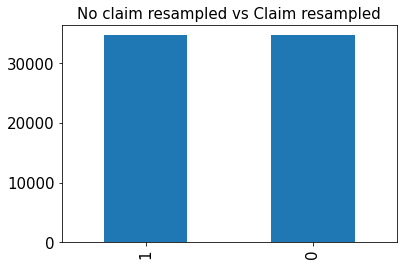

In [38]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

no_claim_resampled, claim_resampled = y_train_resampled.value_counts()
print(f'No claim Resampled {no_claim_resampled}')
print(f'Claim Resampled {claim_resampled}')
print(f'Claim Resampled proportion {round(percentage(claim_resampled, claim_resampled + no_claim_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="No claim resampled vs Claim resampled");

In [39]:
model_resampled = build_model(number_inputs)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor="val_loss", patience=5),
ModelCheckpoint(filepath="best_model.h5", monitor="val_loss", save_best_only=True)]
history_resampled = model_resampled.fit(
    X_train_resampled,
    y_train_resampled,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=callbacks,
    shuffle=True,
)

Epoch 1/100
34/34 [==============================] - 3s 37ms/step - loss: 0.5801 - tp: 24975.0000 - fp: 10895.0000 - tn: 25653.0000 - fn: 9987.0000 - accuracy: 0.7080 - precision: 0.6963 - recall: 0.7143 - auc: 0.7613 - prc: 0.7668 - val_loss: 0.5638 - val_tp: 166.0000 - val_fp: 453.0000 - val_tn: 1370.0000 - val_fn: 71.0000 - val_accuracy: 0.7456 - val_precision: 0.2682 - val_recall: 0.7004 - val_auc: 0.7850 - val_prc: 0.4081
Epoch 2/100
34/34 [==============================] - 0s 10ms/step - loss: 0.5476 - tp: 23027.0000 - fp: 6535.0000 - tn: 28190.0000 - fn: 11698.0000 - accuracy: 0.7375 - precision: 0.7789 - recall: 0.6631 - auc: 0.7871 - prc: 0.8037 - val_loss: 0.5576 - val_tp: 159.0000 - val_fp: 336.0000 - val_tn: 1487.0000 - val_fn: 78.0000 - val_accuracy: 0.7990 - val_precision: 0.3212 - val_recall: 0.6709 - val_auc: 0.7908 - val_prc: 0.4289
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 0.5384 - tp: 22397.0000 - fp: 5635.0000 - tn: 29090.0000 - fn: 1

loss :  0.5375851988792419
tp :  138.0
fp :  230.0
tn :  1593.0
fn :  99.0
accuracy :  0.8402912616729736
precision :  0.375
recall :  0.5822784900665283
auc :  0.7883143424987793
prc :  0.45244333148002625
f1 score: 0.456198347107438

% right for no:  87.38343390016456
% right for yes:  58.22784810126582


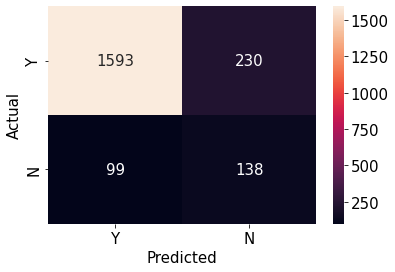

In [40]:
evaluation_results = model_resampled.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_resampled.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_resampled, evaluation_results, y_pred)
plot_cm(y_test, y_pred)

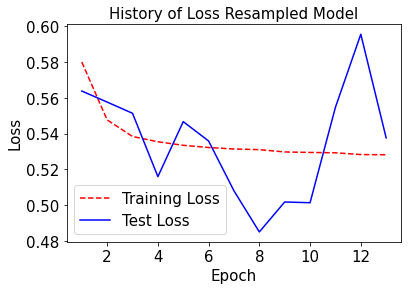

In [41]:
visualise_training_history_loss(history_resampled,"History of Loss Resampled Model")

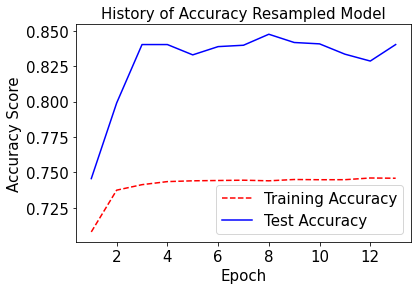

In [42]:
visualise_training_history_accuracy(history_resampled,"History of Accuracy Resampled Model")

# Evaluation

History of Loss Comparison

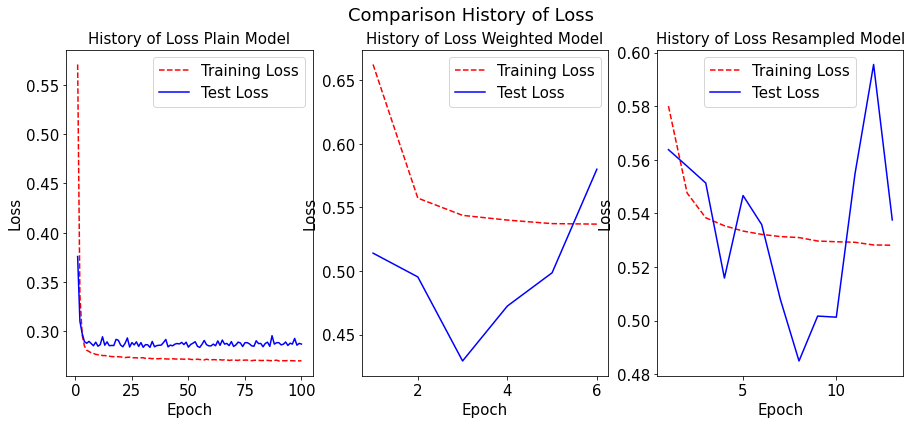

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
fig.suptitle('Comparison History of Loss')
visualise_training_history_loss(ax1, history_plain,"History of Loss Plain Model")
visualise_training_history_loss(ax2, history_weighted,"History of Loss Weighted Model")
visualise_training_history_loss(ax3, history_resampled,"History of Loss Resampled Model")

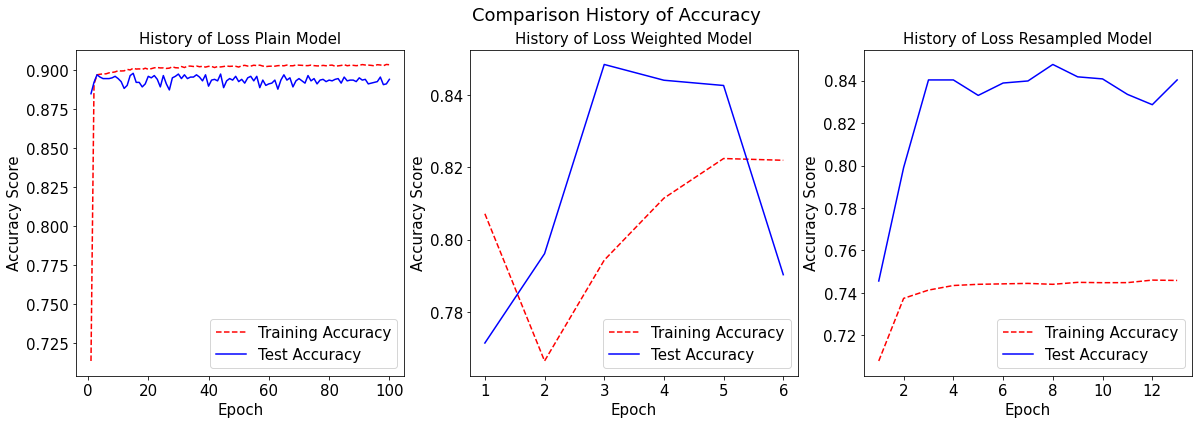

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,6))
fig.suptitle('Comparison History of Accuracy')
visualise_training_history_accuracy(ax1, history_plain,"History of Loss Plain Model")
visualise_training_history_accuracy(ax2, history_weighted,"History of Loss Weighted Model")
visualise_training_history_accuracy(ax3, history_resampled,"History of Loss Resampled Model")

# Tuning

In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 4.3 MB/s 


In [ ]:
import tensorflow as tf
import kerastuner as kt
from tensorflow import keras # importing keras

def model_builder(hp):
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  network = keras.Sequential()
  network.add(layers.Dense(units=hp_units, activation="relu",input_dim=number_inputs))
  network.add(layers.Dense(units=16, activation="relu"))
  network.add(layers.Dense(units=1, activation="sigmoid"))

  network.compile(
    optimizer="rmsprop",
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )
  return network

tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective="val_loss", # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir3', # directory to save logs 
project_name='khyperband')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
# Perform hypertuning
tuner.search(X_train_resampled, y_train_resampled, epochs=10, validation_data=(X_test, y_test))

Trial 21 Complete [00h 00m 31s]
val_loss: 0.5018502473831177

Best val_loss So Far: 0.5018502473831177
Total elapsed time: 00h 08m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
print(tuner.results_summary())
# Build the model with the optimal hyperparameters and train it on the data for N epochs

Results summary
Results in dir3/khyperband
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 160
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5018502473831177
Trial summary
Hyperparameters:
units: 224
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5039137601852417
Trial summary
Hyperparameters:
units: 192
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 29e7088f7f5aa00c158c0eb5b92b3d06
Score: 0.5051102638244629
Trial summary
Hyperparameters:
units: 32
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.5052986145019531
Trial summary
Hyperparameters:
units: 64
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0f292e26782ffddd3b2ab026ae490730
Score: 0.5102987885475159
Trial summary
Hyperparameters:
units: 64
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2


# Architecture

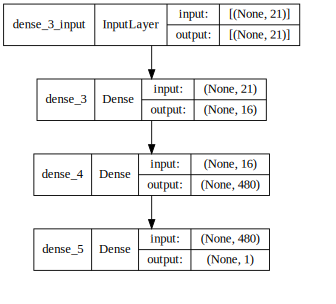

In [43]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_weighted, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))